### Object Localization

<img src="https://blog.kakaocdn.net/dn/clMoGB/btr2PUkjYxh/InSpJZdWj5Mi7Hog4oEl1K/img.png" width="800px" />

$$
\mathbf{y} =
\begin{bmatrix}
    p_c \\
    b_x \\
    b_y \\
    b_h \\
    b_w \\
    c_1 \\
    c_2 \\
    c_3 \\
\end{bmatrix} =
\begin{bmatrix}
    \text{object existance} \\
    \text{bounding box} \\
    \text{bounding box} \\
    \text{bounding box} \\
    \text{bounding box} \\
    \text{object class} \\
    \text{object class} \\
    \text{object class} \\
\end{bmatrix}
$$

$$
\mathcal{L}(\hat{\mathbf {y}}, \mathbf{y}) =
\begin{cases}
    (\hat{\mathbf{y}} - \mathbf{y})^2, & \text{if}\ y_1=1\ (\text{object does exist}) \\
    (\hat{y}_1 - y_1)^2, & \text{if}\ y_1=0\ (\text{object does not exist})
\end{cases}
$$

cross-entropy loss for object class losses and logistic loss for object existance could be okay too.

### Landmark Detection

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*kmu_t1iNbOipwozjxCG6og.jpeg" width="200px" />

$$
\mathbf{y} =
\begin{bmatrix}
    p \\
    l_{1,x} \\
    l_{1,y} \\
    \vdots \\
    l_{64,x} \\
    l_{64,y} \\
\end{bmatrix} =
\begin{bmatrix}
    \text{object existance} \\
    \text{landmarks} \\
    \text{landmarks} \\
    \vdots \\
    \text{landmarks} \\
    \text{landmarks}
\end{bmatrix}
$$

$$
\mathcal{L}(\hat{\mathbf {y}}, \mathbf{y}) =
\begin{cases}
    (\hat{\mathbf{y}} - \mathbf{y})^2, & \text{if}\ y_1=1\ (\text{object does exist}) \\
    (\hat{y}_1 - y_1)^2, & \text{if}\ y_1=0\ (\text{object does not exist})
\end{cases}
$$

cross-entropy loss for object class losses and logistic loss for object existance could be okay too.

### Object Detection
using sliding windows! (sliding windows detection can be very costly when used with ConvNets)

Instead of flattening the last latent feature, we can use Conv2d which can be parallelized.\
There are some downsides of sliding windows algo. One is that the bounding box is inaccurate due to multiple size-reducing-layers such as Conv, Pool etc. The other is that the bounding box cannot be rectangular shaped.

torch.Size([1, 3, 28, 28])
torch.Size([1, 1, 1, 1])
tensor([[[[0.0638]]]], grad_fn=<ConvolutionBackward0>)

torch.Size([1, 3, 224, 224])
torch.Size([1, 1, 50, 50])
tensor([[[[0.0703, 0.0684, 0.0585,  ..., 0.0682, 0.0658, 0.0502],
          [0.0805, 0.0736, 0.0565,  ..., 0.0610, 0.0458, 0.0641],
          [0.0764, 0.0652, 0.0598,  ..., 0.0582, 0.0643, 0.0663],
          ...,
          [0.0736, 0.0652, 0.0703,  ..., 0.0633, 0.0642, 0.0555],
          [0.0717, 0.0602, 0.0570,  ..., 0.0587, 0.0513, 0.0572],
          [0.0708, 0.0719, 0.0611,  ..., 0.0600, 0.0570, 0.0549]]]],
       grad_fn=<ConvolutionBackward0>)


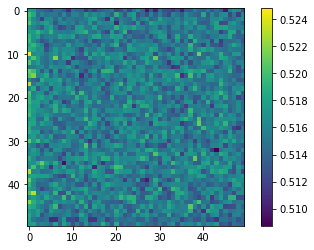

In [180]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

class Detector(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=5, padding=2)
        self.maxpool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

        self.convpool = nn.Conv2d(256, 256, kernel_size=7)
        self.fc1 = nn.Conv2d(256, 64, kernel_size=1)
        self.fc2 = nn.Conv2d(64, 1, kernel_size=1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.convpool(x)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = Detector()

x = torch.randn(1,3,28,28) # sliding window size (3x28x28)
y_hat = model(x)
print(x.shape)
print(y_hat.shape)
print(y_hat)
print()

x = torch.randn(1,3,224,224) # (3x224x224) image with sliding window size (3x28x28)
y_hat = model(x)
print(x.shape)
print(y_hat.shape)
print(y_hat)

plt.imshow(y_hat.squeeze().sigmoid().detach().numpy())
plt.colorbar()
plt.show()

### YOLO algorithm

Image localization in a 19x19 grid

In [182]:
import torch
import torch.nn as nn
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

x = torch.zeros(1,3,608,608)

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])